In [ ]:
!pip install pennylane-lightning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.templates import QFT
import matplotlib.image as mpimg
from itertools import product
from tqdm import tqdm
from collections import Counter

In [ ]:
def rgb2gray(rgb):
    """ Convert an RGB digital image to greyscale. """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
def vectorization(img, Cr, Cc, renorm=False):
    "Vectorize the image into amplitude-encoding patches suitable for quantum circuits"
    # split the original image (Mr, Mc) into S equal-size patches of shape (Cr, Cc)
    Mr, Mc = img.shape
    patches = (img.reshape(Mc//Cr, Cr, -1, Cc).swapaxes(1, 2).reshape(-1, Cr, Cc))
    # 64 patches, (64, 64, 64) shape; S=64

    # vectorize each patch and collect all in a (N, Cr*Cc) array
    vect_patches = np.reshape(patches,  (patches.shape[0], Cr*Cc)) # (64, 4096)

    # normalize each (Cr*Cc) vector to the intensity of the corresponding (Cr, Cc) patch
    states = np.zeros((patches.shape[0], Cr*Cc)) # (64, 4096)
    norm = np.zeros(patches.shape[0])

    for idx in range(patches.shape[0]): # for each patch
        # compute the sum of pixels intensities
        norm[idx] = vect_patches[idx].sum()
        if norm[idx] == 0:
            raise ValueError('Pixel value is 0')
        # normalize the patch vector so that its entries sum is 1
        tmp = vect_patches[idx] / norm[idx]
        # take the element-wise square root of the normalized vector
        states[idx] = np.sqrt(tmp)
    if renorm == False:
        norm = np.ones(patches.shape[0])
    print(states[:10])

    return states, norm # amplitudes, pixek intensities' sums

In [ ]:
def apply_qft(n0):
    qml.templates.QFT(wires=list(range(n0)))

def apply_iqft(n1):
    qml.adjoint(qml.templates.QFT)(wires=list(range(n1)))

In [ ]:
def circuit_builder(states, n0, n2, shots):
    """Create a list of n-qubit quantum circuits using PennyLane,
    each initialized with states[idx]. For each circuit:
        1. Perform QFT on all n0 qubits
        2. Apply IQFT on the first n1 = n0 - (n0-n2)//2 qubits
        3. Discard qubits from the middle (don't measure them),
           measure the rest (n2 qubits).
    Return a list of qnode functions (circuits).
    """

    ntilde = (n0 - n2) // 2 #
    n1 = n0 - ntilde

    qnodes = []

    # Define device with n0 wires
    dev = qml.device("lightning.qubit", wires=n0, shots=shots)  # analytic

    for idx in range(states.shape[0]):
        # Define the QNode (circuit) capturing the current input state
        @qml.qnode(dev)
        def circuit():
            print("State norm:", np.linalg.norm(states[idx]))
            # Initialize state
            qml.AmplitudeEmbedding(states[idx], wires=range(n0), validate_norm=True,  normalize=True)

            # Optional Hadamard on all qubits (improves reconstruction)
            for w in range(n0):
                qml.Hadamard(wires=w)

            # QFT on all qubits
            #QFT(wires=range(n0))
            #for i in range(n0 // 2):
             #   qml.SWAP(wires=[i, n0 - i - 1])

            # IQFT on first n1 qubits
            #qml.adjoint(QFT)(wires=range(n1))
            #for i in range(n1 // 2):
            #    qml.SWAP(wires=[i, n1 - i - 1])

            discard_start = n0 // 2 - ntilde
            discard_end = n0 // 2 - 1
            discarded_qubits = set(range(discard_start, discard_end + 1))

            measured_qubits = [q for q in range(n1) if q not in discarded_qubits]


            for q in measured_qubits:
                qml.Hadamard(wires=q)

            print(f'Measured qubits: {measured_qubits}')

            return qml.probs(wires=measured_qubits)
        qnodes.append(circuit)

    return qnodes


In [ ]:
def reconstruction(qnodes, n2, norm):
    out_freq = np.zeros((len(qnodes), 2**n2))
    for idx, qnode in enumerate(qnodes):
        probs = qnode()  # already a vector of length 2**n2
        print(f"Circuit {idx} probs:", probs)
        out_freq[idx, :] = probs * norm[idx]
    return out_freq

In [ ]:
def devectorization(out_freq):
    S = out_freq.shape[0] # Number of patches
    nrow = int(np.sqrt(out_freq.shape[1])) # Number of rows of each patch
    ncol = nrow # Number of columns of each compressed patch

    decoded_patches = np.reshape(out_freq,\
                      (out_freq.shape[0], nrow, ncol)) # Shape (S, nrow, ncol)

    im_h, im_w = nrow*int(np.sqrt(S)), ncol*int(np.sqrt(S)) # Final shape

    decoded_img = np.zeros((im_w, im_h)) # Initialization

    idx = 0
    for row in np.arange(im_h - nrow + 1, step=nrow):
        for col in np.arange(im_w - ncol + 1, step=ncol):
            decoded_img[row:row+nrow, col:col+ncol] = decoded_patches[idx]
            idx += 1

    return decoded_img

The resolution is 512 x 512 pixels. There are 262144 pixels.


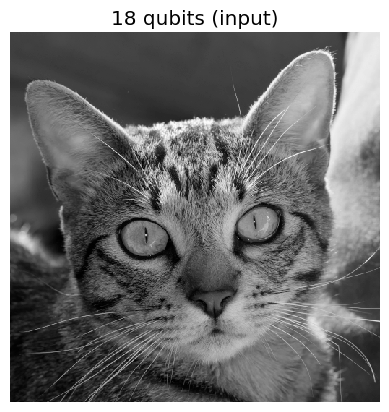

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/input2.jpg') # Load the input image
# img = np.array(list(zip(*img[::-1]))) # Rotate the image

if len(img.shape) != 2:
    img = rgb2gray(img) # Convert an RGB image to greyscale

bitdepth = 8 # Depth
black, white = 0, 2**bitdepth - 1

plt.rcParams.update({'font.size': 12})
# plt.rcParams['figure.figsize'] = [4, 4] # Resize the output canvas

Mr, Mc = img.shape
print('The resolution is', Mr, 'x', Mc, 'pixels.',\
      'There are', np.size(img), 'pixels.')

# np.savetxt('output/data/input' + str(int(np.log2(Mr*Mc)))\
#           + 'q' + '.txt', img, fmt='%u') # Save
# np.save('output/data/input' + str(int(np.log2(Mr*Mc)))\
#                   + 'q' + '.npy', img) # Save

plt.imshow(img, cmap='gray', vmin = black, \
           vmax = white, interpolation = 'none')

plt.title('%i qubits (input)' %np.log2(Mr*Mc))
plt.axis('off')
filename = 'output/images/input' + str(int(np.log2(Mr*Mc))) + 'q' + '.png'

# Save
# plt.savefig(filename, bbox_inches='tight') # Upscale
# plt.imsave(fname=filename, arr=img, cmap='gray', \
#           vmin = black, vmax = white, format='png') # Faithful

plt.show()

In [ ]:
Cr,Cc = Mr, Mc
states, norm = vectorization(img, Cr, Cc)
n0 = int(np.log2(Cr*Cc)) # Number of qubits for each circuit

print('The shape of the vectorized image is ', states.shape,\
      '. It will be loaded in ', states.shape[0],\
          ' circuit(s) of ' , n0, ' qubits.', sep='')

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
The shape of the vectorized image is (1, 262144). It will be loaded in 1 circuit(s) of 18 qubits.


  0%|          | 0/8 [00:00<?, ?it/s]

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=16777216) at 0x7d8c604d5590>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]
Circuit 0 probs: [9.35792923e-06 1.02519989e-05 9.47713852e-06 ... 4.76837158e-06
 5.18560410e-06 4.29153442e-06]
[[9.35792923e-06 1.02519989e-05 9.47713852e-06 ... 4.76837158e-06
  5.18560410e-06 4.29153442e-06]]


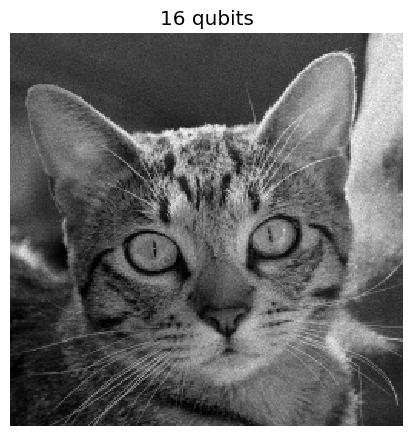

 12%|█▎        | 1/8 [00:15<01:47, 15.40s/it]

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=4194304) at 0x7d8c62fec7d0>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [4.19616699e-05 4.00543213e-05 4.38690186e-05 ... 2.00271606e-05
 2.16960907e-05 2.28881836e-05]
[[4.19616699e-05 4.00543213e-05 4.38690186e-05 ... 2.00271606e-05
  2.16960907e-05 2.28881836e-05]]


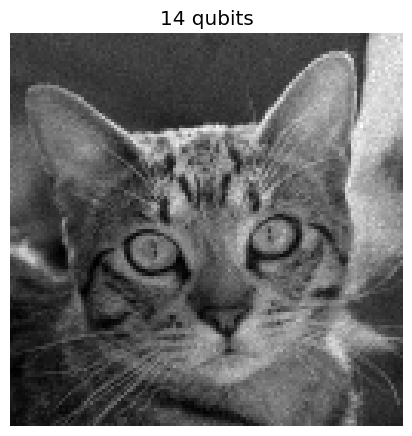

 25%|██▌       | 2/8 [00:17<00:44,  7.48s/it]

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=1048576) at 0x7d8c6120ec50>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]
Circuit 0 probs: [1.54495239e-04 1.63078308e-04 1.65939331e-04 ... 8.77380371e-05
 8.96453857e-05 8.67843628e-05]
[[1.54495239e-04 1.63078308e-04 1.65939331e-04 ... 8.77380371e-05
  8.96453857e-05 8.67843628e-05]]


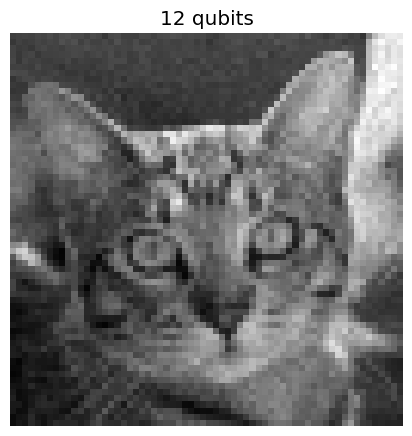

 38%|███▊      | 3/8 [00:17<00:21,  4.33s/it]

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=262144) at 0x7d8c60139f10>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 9, 10, 11, 12, 13]
Circuit 0 probs: [0.00070572 0.00056839 0.00062561 ... 0.00044632 0.00043106 0.00045013]
[[0.00070572 0.00056839 0.00062561 ... 0.00044632 0.00043106 0.00045013]]


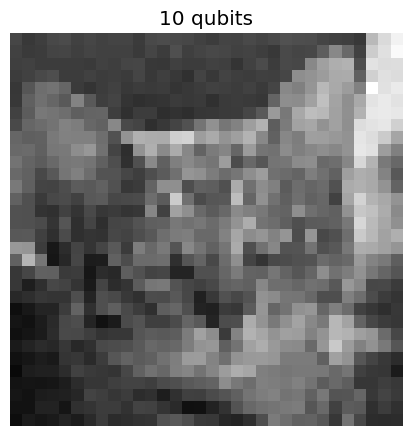

 50%|█████     | 4/8 [00:18<00:10,  2.71s/it]

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=65536) at 0x7d8c60a48810>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 9, 10, 11, 12]
Circuit 0 probs: [0.00247192 0.00286865 0.00262451 0.00308228 0.00247192 0.00283813
 0.00289917 0.00244141 0.00276184 0.00260925 0.00247192 0.00265503
 0.00340271 0.00358582 0.00566101 0.00917053 0.0025177  0.0025177
 0.00283813 0.00260925 0.00291443 0.00283813 0.00268555 0.00228882
 0.00248718 0.00315857 0.00256348 0.00317383 0.0067749  0.00671387
 0.0057373  0.00967407 0.00279236 0.00450134 0.0040741  0.00247192
 0.00224304 0.00205994 0.00242615 0.00236511 0.00247192 0.00265503
 0.00276184 0.00553894 0.00709534 0.00672913 0.00679016 0.00917053
 0.00286865 0.00517273 0.00483704 0.0038147  0.00335693 0.00221252
 0.00218201 0.00296021 0.0032959  0.00367737 0.00526428 0.00566101
 0.00671387 0.0063324 

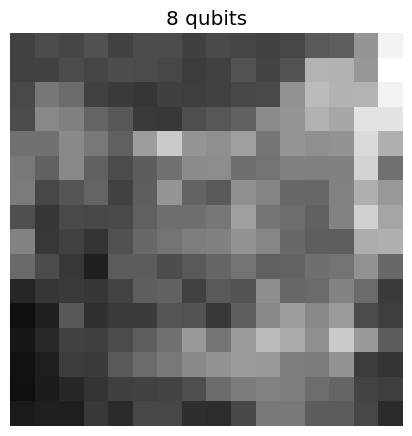

 62%|██████▎   | 5/8 [00:18<00:05,  1.81s/it]

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=16384) at 0x7d8c62e99110>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 9, 10, 11]
Circuit 0 probs: [0.01068115 0.01074219 0.01135254 0.01086426 0.01080322 0.01245117
 0.01977539 0.02984619 0.01556396 0.01397705 0.00994873 0.00976562
 0.01446533 0.01928711 0.02740479 0.03308105 0.01568604 0.02032471
 0.01623535 0.02203369 0.01940918 0.0189209  0.02026367 0.02740479
 0.01055908 0.01116943 0.01031494 0.01879883 0.01971436 0.01763916
 0.01776123 0.02746582 0.01434326 0.00769043 0.01403809 0.0145874
 0.01953125 0.015625   0.01757812 0.02368164 0.00701904 0.00933838
 0.01019287 0.01348877 0.01245117 0.02044678 0.01983643 0.01177979
 0.00421143 0.01043701 0.01330566 0.01983643 0.02233887 0.02386475
 0.02301025 0.01287842 0.00445557 0.00756836 0.00793457 0.0088501
 0.01464844 0.01715088 0.01586

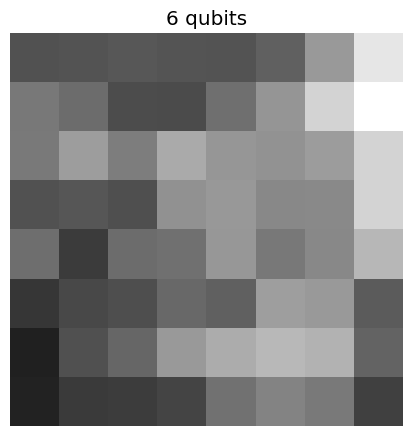

 75%|███████▌  | 6/8 [00:18<00:02,  1.25s/it]

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=4096) at 0x7d8c60352650>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999999
Measured qubits: [0, 1, 9, 10]
Circuit 0 probs: [0.05419922 0.03710938 0.04980469 0.10473633 0.05517578 0.07885742
 0.0847168  0.09545898 0.04003906 0.05102539 0.06445312 0.06835938
 0.0222168  0.05004883 0.07666016 0.06713867]
[[0.05419922 0.03710938 0.04980469 0.10473633 0.05517578 0.07885742
  0.0847168  0.09545898 0.04003906 0.05102539 0.06445312 0.06835938
  0.0222168  0.05004883 0.07666016 0.06713867]]


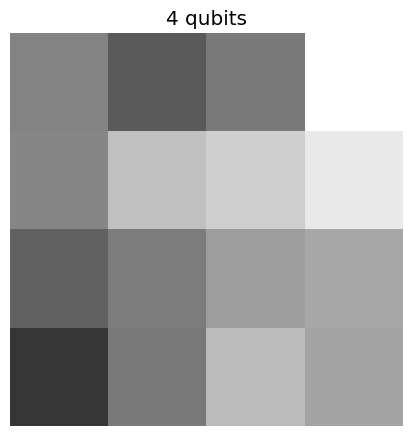

 88%|████████▊ | 7/8 [00:18<00:00,  1.12it/s]

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=1024) at 0x7d8c60e069d0>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999999
Measured qubits: [0, 9]
Circuit 0 probs: [0.23242188 0.31542969 0.17773438 0.27441406]
[[0.23242188 0.31542969 0.17773438 0.27441406]]


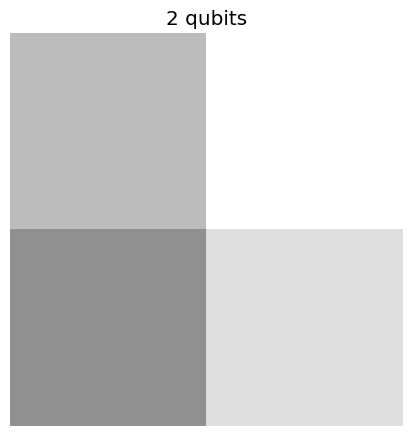

100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


In [ ]:
for n2 in tqdm(range(n0-2, 0, -2)):
    shots = 2**(n2+bitdepth)

    states, norm = vectorization(img, Cr, Cc)
    qcs = circuit_builder(states, n0, n2, shots)
    print(qcs)
    print(f'QCS are built: {len(qcs)}')
    out_freq = reconstruction(qcs, n2, norm)
    print(out_freq)
    final_img = devectorization(out_freq)*shots

    black, white = 0, 2**bitdepth - 1
    final_img = final_img/final_img.max()*white

    plt.imshow(final_img, cmap='gray', vmin = black, vmax = white,\
               interpolation = 'none')

    plt.title('%i qubits' %n2)
    plt.tight_layout()
    plt.axis('off')

    # Save
    filename = 'output/images/output' + str(n2) + 'q' + '.png'

    plt.show()
    plt.close()

In [ ]:
trials = 20
n2 = 14

final_images = np.zeros((trials,2**(n2)))

states, norm = vectorization(img, Cr, Cc)
qcs = circuit_builder(states, n0, n2, shots)

[[0.00161416 0.00161416 0.00160207 ... 0.00119651 0.0011839  0.0011839 ]]


In [ ]:
print('Standard deviation estimation...')

for idx in tqdm(range(trials)):
    shots = 2**(n2)
    out_freq = reconstruction(qcs, n2, norm)
    final_img = devectorization(out_freq)*shots

    black, white = 0, 255
    final_img = final_img/final_img.max()*white

    final_images[idx,:] = np.reshape(final_img, 2**n2)

stds = np.std(final_images, axis=0)

Standard deviation estimation...


 30%|███       | 6/20 [00:00<00:00, 50.53it/s]

State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Mea

 90%|█████████ | 18/20 [00:00<00:00, 47.74it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0.         0.         0.         ... 0.         0.         0.00097656]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0.         0.         0.00097656 ... 0.         0.         0.        ]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999999
Meas

100%|██████████| 20/20 [00:00<00:00, 48.18it/s]


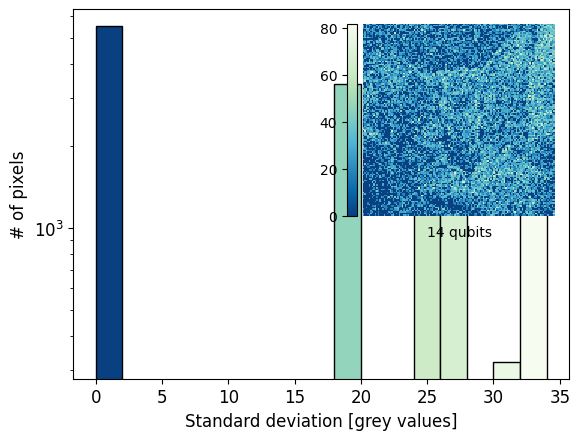

In [ ]:
fig, ax1 = plt.subplots()
cmap = plt.cm.GnBu_r

bins = np.arange(0,35,2)
# bins = np.arange(0,4.5,0.5) # Uncomment when Hadamard is off
h_n, h_bins, h_patches = ax1.hist(stds, bins = bins, edgecolor='black', linewidth = 1)
plt.yscale('log',base=10)

# Set the color of each bin, accordingly to the value plotted in the inset
bin_centers = 0.5 * (h_bins[:-1] + h_bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, h_patches):
    plt.setp(p, 'facecolor', cmap(c))

# ax1.set_xlim([-0.5, 6.5]) # Uncomment when Hadamard is off
ax1.set_xlabel('Standard deviation [grey values]')
ax1.set_ylabel('# of pixels')

# Plot the inset
left, bottom, width, height = [0.508, 0.45, 0.4, 0.40]
ax2 = fig.add_axes([left, bottom, width, height])

stds_mtx = np.reshape(stds, (2**(n2//2), 2**(n2//2)))
cax = ax2.matshow(stds_mtx, cmap=cmap, interpolation = 'none')
ax2.axis('off')
ax2.set_title(str(n2) + ' qubits', fontsize=10, y=-0.15)
cbar = fig.colorbar(cax, location='left', pad= 0.025)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("output/plots/StatisticalFluctuations.pdf", format="pdf")
plt.show()